# EdgeFace: MTCNN vs YuNet Face Detection & Alignment Comparison

이 노트북에서는 EdgeFace-XS(γ=0.6) 모델 평가를 위해 MTCNN과 YuNet 기반 face detection 및 alignment의 성능과 속도를 비교합니다.

## 목표
1. MTCNN(CPU) vs YuNet(CPU) 추론 속도 비교
2. Face alignment 결과 시각적 비교
3. EdgeFace 모델 성능에 미치는 영향 분석
4. 메모리 사용량 비교

In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from PIL import Image
from torchvision import transforms
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 시스템에 설치된 한글 폰트 확인 및 설정
import matplotlib.font_manager as fm

# 사용 가능한 한글 폰트 찾기
available_fonts = [f.name for f in fm.fontManager.ttflist]
korean_fonts = ['NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 'AppleGothic', 'D2Coding']

selected_font = None
for font in korean_fonts:
    if font in available_fonts:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    print(f"한글 폰트 설정: {selected_font}")
else:
    # 폰트가 없을 경우 유니코드 지원 폰트 사용
    try:
        # Linux의 경우 Noto Sans CJK 시도
        if os.path.exists('/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc'):
            plt.rcParams['font.family'] = 'Noto Sans CJK KR'
        elif os.path.exists('/System/Library/Fonts/AppleSDGothicNeo.ttc'):  # macOS
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
        else:
            # 기본 설정으로 fallback
            plt.rcParams['font.family'] = 'sans-serif'
        print("기본 한글 폰트 설정 완료")
    except:
        print("한글 폰트 설정 실패 - 기본 폰트 사용")

# EdgeFace 관련 import
from backbones import get_model
from face_alignment.align_cpu import get_aligned_face_cpu
from face_alignment.yunet import YuNetDetector, get_aligned_face_yunet

print("라이브러리 로딩 완료")

한글 폰트 설정: NanumGothic
라이브러리 로딩 완료


## 1. 모델 및 설정 초기화

In [2]:
# EdgeFace 모델 로드
arch = "edgeface_xs_gamma_06"
model = get_model(arch)
checkpoint_path = f'checkpoints/{arch}.pt'

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"EdgeFace 모델 로드 완료: {arch}")
else:
    print(f"체크포인트 파일이 없습니다: {checkpoint_path}")
    print("허브에서 모델을 로드합니다...")
    model = torch.hub.load('otroshi/edgeface', arch, source='github', pretrained=True)

model.eval()

# 이미지 전처리 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

print("EdgeFace 모델 준비 완료")

EdgeFace 모델 로드 완료: edgeface_xs_gamma_06
EdgeFace 모델 준비 완료


In [3]:
# YuNet 모델 경로 설정
yunet_model_path = "libfacedetection/opencv_zoo/models/face_detection_yunet/face_detection_yunet_2023mar.onnx"

if not os.path.exists(yunet_model_path):
    print(f"YuNet 모델 파일이 없습니다: {yunet_model_path}")
    print("현재 디렉토리의 YuNet 모델을 찾는 중...")
    import glob
    yunet_files = glob.glob("**/face_detection_yunet_2023mar.onnx", recursive=True)
    if yunet_files:
        yunet_model_path = yunet_files[0]
        print(f"YuNet 모델 발견: {yunet_model_path}")
    else:
        print("YuNet 모델을 찾을 수 없습니다.")
else:
    print(f"YuNet 모델 경로 확인: {yunet_model_path}")

# YuNet 검출기 초기화
yunet_detector = None
try:
    if os.path.exists(yunet_model_path):
        yunet_detector = YuNetDetector(yunet_model_path, device='cpu', crop_size=(112, 112))
        print("YuNet 검출기 초기화 완료")
    else:
        print("YuNet 모델 파일이 존재하지 않습니다.")
except Exception as e:
    print(f"YuNet 초기화 오류: {e}")
    print("YuNet 기능이 비활성화됩니다.")
    
# YuNet 사용 가능 여부 확인
yunet_available = yunet_detector is not None
print(f"YuNet 사용 가능: {yunet_available}")

YuNet 모델 경로 확인: libfacedetection/opencv_zoo/models/face_detection_yunet/face_detection_yunet_2023mar.onnx
YuNet 검출기 초기화 완료
YuNet 사용 가능: True


## 2. 테스트 이미지 준비

In [4]:
# 테스트 이미지 경로 설정
test_images = []

# 1. 기존 체크포인트 디렉토리의 샘플 이미지 확인
# if os.path.exists('checkpoints/synthface.jpeg'):
#     test_images.append('checkpoints/synthface.jpeg')

# 2. libfacedetection의 샘플 이미지들 확인
sample_dir = "face_alignment/test_images"
if os.path.exists(sample_dir):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        import glob
        test_images.extend(glob.glob(f"{sample_dir}/{ext}"))

# 3. opencv_zoo의 샘플 이미지들 확인 (gif 제외)
opencv_sample_dir = "libfacedetection/opencv_zoo/models/face_detection_yunet/example_outputs"
if os.path.exists(opencv_sample_dir):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        import glob
        test_images.extend(glob.glob(f"{opencv_sample_dir}/{ext}"))

# 유효한 이미지 파일만 필터링
valid_test_images = []
print(f"발견된 테스트 이미지: {len(test_images)}개")

for img_path in test_images:
    try:
        # 이미지 로드 테스트
        with Image.open(img_path) as img:
            img.verify()  # 이미지 유효성 검사
        valid_test_images.append(img_path)
        print(f"  ✅ {os.path.basename(img_path)}")
    except Exception as e:
        print(f"  ❌ {os.path.basename(img_path)} - 손상된 파일: {e}")

test_images = valid_test_images

if len(test_images) == 0:
    print("\n유효한 테스트 이미지를 찾을 수 없습니다. 기본 이미지를 생성합니다...")
    # 기본 테스트 이미지 생성 (단색 이미지)
    default_img = Image.new('RGB', (224, 224), color='white')
    default_img.save('test_sample.jpg')
    test_images = ['test_sample.jpg']
    print("기본 테스트 이미지 생성 완료")

print(f"\n최종 유효 테스트 이미지: {len(test_images)}개")

발견된 테스트 이미지: 4개
  ✅ img2.jpeg
  ✅ img3.jpeg
  ✅ img1.jpeg
  ❌ largest_selfie.jpg - 손상된 파일: cannot identify image file 'libfacedetection/opencv_zoo/models/face_detection_yunet/example_outputs/largest_selfie.jpg'

최종 유효 테스트 이미지: 3개


## 3. 속도 벤치마크 함수 정의

In [5]:
def measure_inference_time(detector_func, image_path, num_runs=10):
    """
    검출기의 추론 시간을 측정합니다.
    
    Args:
        detector_func: 검출 함수
        image_path: 이미지 경로
        num_runs: 반복 실행 횟수
    
    Returns:
        (avg_time, std_time, success_rate): 평균 시간, 표준편차, 성공률
    """
    times = []
    successes = 0
    
    # 워밍업
    try:
        detector_func(image_path)
    except:
        pass
    
    for _ in range(num_runs):
        try:
            start_time = time.time()
            result = detector_func(image_path)
            end_time = time.time()
            
            if result is not None:
                times.append(end_time - start_time)
                successes += 1
        except Exception as e:
            print(f"오류 발생: {e}")
            continue
    
    if len(times) > 0:
        avg_time = np.mean(times) * 1000  # ms로 변환
        std_time = np.std(times) * 1000
        success_rate = successes / num_runs
    else:
        avg_time, std_time, success_rate = 0, 0, 0
    
    return avg_time, std_time, success_rate

def measure_memory_usage():
    """
    현재 프로세스의 메모리 사용량을 측정합니다.
    """
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / 1024 / 1024  # MB로 변환

print("벤치마크 함수 정의 완료")

벤치마크 함수 정의 완료


## 4. EdgeFace 추론 함수 정의

In [6]:
def get_edgeface_embedding(aligned_face):
    """
    Aligned face로부터 EdgeFace embedding을 추출합니다.
    
    Args:
        aligned_face: PIL Image (112x112)
    
    Returns:
        embedding: torch.Tensor
    """
    if aligned_face is None:
        return None
    
    try:
        # 이미지 전처리
        input_tensor = transform(aligned_face).unsqueeze(0)
        
        # EdgeFace 추론
        with torch.no_grad():
            embedding = model(input_tensor)
        
        return embedding
    except Exception as e:
        print(f"EdgeFace 추론 오류: {e}")
        return None

def mtcnn_pipeline(image_path):
    """
    MTCNN을 사용한 전체 파이프라인 (Detection + Alignment + EdgeFace)
    """
    aligned_face = get_aligned_face_cpu(image_path)
    if aligned_face is None:
        return None
    embedding = get_edgeface_embedding(aligned_face)
    return embedding

def yunet_pipeline(image_path):
    """
    YuNet을 사용한 전체 파이프라인 (Detection + Alignment + EdgeFace)
    """
    global yunet_detector, yunet_available
    if not yunet_available or yunet_detector is None:
        return None
        
    try:
        img = Image.open(image_path).convert('RGB')
        aligned_face = yunet_detector.align(img)
        if aligned_face is None:
            return None
        embedding = get_edgeface_embedding(aligned_face)
        return embedding
    except Exception as e:
        print(f"YuNet 파이프라인 오류: {e}")
        return None

def safe_yunet_align(image_path):
    """
    안전한 YuNet alignment 함수 (global 변수 명시적 참조)
    """
    global yunet_detector, yunet_available
    if not yunet_available or yunet_detector is None:
        return None
    try:
        img = Image.open(image_path).convert('RGB')
        return yunet_detector.align(img)
    except Exception as e:
        print(f"YuNet alignment 오류: {e}")
        return None

# 전역 변수 확인 함수
def check_yunet_status():
    """
    YuNet 상태를 확인하는 함수
    """
    global yunet_detector, yunet_available
    print(f"yunet_available: {yunet_available}")
    print(f"yunet_detector is None: {yunet_detector is None}")
    return yunet_available and yunet_detector is not None

print("EdgeFace 추론 함수 정의 완료")
print(f"현재 YuNet 상태: {check_yunet_status()}")

EdgeFace 추론 함수 정의 완료
yunet_available: True
yunet_detector is None: False
현재 YuNet 상태: True


## 5. 성능 벤치마크 실행

In [7]:
# 전역 변수 확인
global yunet_detector, yunet_available

# 벤치마크 결과를 저장할 리스트
benchmark_results = []

print("MTCNN vs YuNet 성능 벤치마크 시작...")
print(f"테스트 이미지 수: {len(test_images[:3])}개")  # 처음 3개 이미지만 테스트
print(f"YuNet 사용 가능: {yunet_available}")
print("="*60)

for i, image_path in enumerate(test_images[:3]):
    print(f"\n이미지 {i+1}: {os.path.basename(image_path)}")
    
    try:
        # 이미지 로드 및 기본 정보
        img = Image.open(image_path)
        img_size = img.size
        print(f"이미지 크기: {img_size}")
        
        # MTCNN 벤치마크
        print("MTCNN 테스트 중...")
        mem_before_mtcnn = measure_memory_usage()
        mtcnn_time, mtcnn_std, mtcnn_success = measure_inference_time(
            get_aligned_face_cpu, image_path, num_runs=5
        )
        mem_after_mtcnn = measure_memory_usage()
        mtcnn_memory = mem_after_mtcnn - mem_before_mtcnn
        
        # YuNet 벤치마크
        if yunet_available and yunet_detector is not None:
            print("YuNet 테스트 중...")
            mem_before_yunet = measure_memory_usage()
            
            # 직접 lambda 함수로 정의해서 전역 변수 의존성 제거
            def yunet_align_wrapper(path):
                try:
                    img_temp = Image.open(path).convert('RGB')
                    return yunet_detector.align(img_temp)
                except Exception as e:
                    print(f"YuNet wrapper 오류: {e}")
                    return None
            
            yunet_time, yunet_std, yunet_success = measure_inference_time(
                yunet_align_wrapper, image_path, num_runs=5
            )
            mem_after_yunet = measure_memory_usage()
            yunet_memory = mem_after_yunet - mem_before_yunet
        else:
            print("YuNet을 사용할 수 없습니다 - 건너뜀")
            yunet_time, yunet_std, yunet_success, yunet_memory = 0, 0, 0, 0
        
        # 결과 저장
        result = {
            'image': os.path.basename(image_path),
            'image_size': f"{img_size[0]}x{img_size[1]}",
            'mtcnn_time_ms': mtcnn_time,
            'mtcnn_std_ms': mtcnn_std,
            'mtcnn_success_rate': mtcnn_success,
            'mtcnn_memory_mb': mtcnn_memory,
            'yunet_time_ms': yunet_time,
            'yunet_std_ms': yunet_std,
            'yunet_success_rate': yunet_success,
            'yunet_memory_mb': yunet_memory,
            'speedup_ratio': mtcnn_time / yunet_time if yunet_time > 0 else 0
        }
        benchmark_results.append(result)
        
        # 중간 결과 출력
        print(f"  MTCNN: {mtcnn_time:.1f}±{mtcnn_std:.1f}ms (성공률: {mtcnn_success:.1%})")
        if yunet_available:
            print(f"  YuNet: {yunet_time:.1f}±{yunet_std:.1f}ms (성공률: {yunet_success:.1%})")
            print(f"  속도 향상: {result['speedup_ratio']:.2f}x")
        else:
            print(f"  YuNet: 사용 불가")
        
    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n벤치마크 완료!")

MTCNN vs YuNet 성능 벤치마크 시작...
테스트 이미지 수: 3개
YuNet 사용 가능: True

이미지 1: img2.jpeg
이미지 크기: (201, 251)
MTCNN 테스트 중...
YuNet 테스트 중...
  MTCNN: 13.5±3.0ms (성공률: 100.0%)
  YuNet: 2.8±0.4ms (성공률: 100.0%)
  속도 향상: 4.81x

이미지 2: img3.jpeg
이미지 크기: (1168, 998)
MTCNN 테스트 중...
YuNet 테스트 중...
  MTCNN: 130.8±13.7ms (성공률: 100.0%)
  YuNet: 17.4±1.6ms (성공률: 100.0%)
  속도 향상: 7.53x

이미지 3: img1.jpeg
이미지 크기: (259, 194)
MTCNN 테스트 중...
YuNet 테스트 중...
  MTCNN: 9.6±0.4ms (성공률: 100.0%)
  YuNet: 2.4±0.6ms (성공률: 100.0%)
  속도 향상: 3.96x

벤치마크 완료!


## 6. 결과 시각화 및 분석

In [8]:
# 결과를 DataFrame으로 변환
if benchmark_results:
    df_results = pd.DataFrame(benchmark_results)
    
    print("=== 벤치마크 결과 요약 ===")
    print(df_results.to_string(index=False))
    
    # 평균 성능 계산
    avg_mtcnn_time = df_results['mtcnn_time_ms'].mean()
    avg_yunet_time = df_results['yunet_time_ms'].mean()
    avg_speedup = df_results['speedup_ratio'].mean()
    
    print(f"\n=== 평균 성능 ===")
    print(f"MTCNN 평균 추론 시간: {avg_mtcnn_time:.1f}ms")
    print(f"YuNet 평균 추론 시간: {avg_yunet_time:.1f}ms")
    print(f"평균 속도 향상: {avg_speedup:.2f}x")
    
else:
    print("벤치마크 결과가 없습니다.")

=== 벤치마크 결과 요약 ===
    image image_size  mtcnn_time_ms  mtcnn_std_ms  mtcnn_success_rate  mtcnn_memory_mb  yunet_time_ms  yunet_std_ms  yunet_success_rate  yunet_memory_mb  speedup_ratio
img2.jpeg    201x251      13.450813      3.039857                 1.0        11.925781       2.794456      0.381929                 1.0        14.964844       4.813392
img3.jpeg   1168x998     130.786657     13.668913                 1.0        12.011719      17.359066      1.649924                 1.0       109.285156       7.534199
img1.jpeg    259x194       9.613466      0.352163                 1.0         0.257812       2.426577      0.641643                 1.0      -110.710938       3.961740

=== 평균 성능 ===
MTCNN 평균 추론 시간: 51.3ms
YuNet 평균 추론 시간: 7.5ms
평균 속도 향상: 5.44x


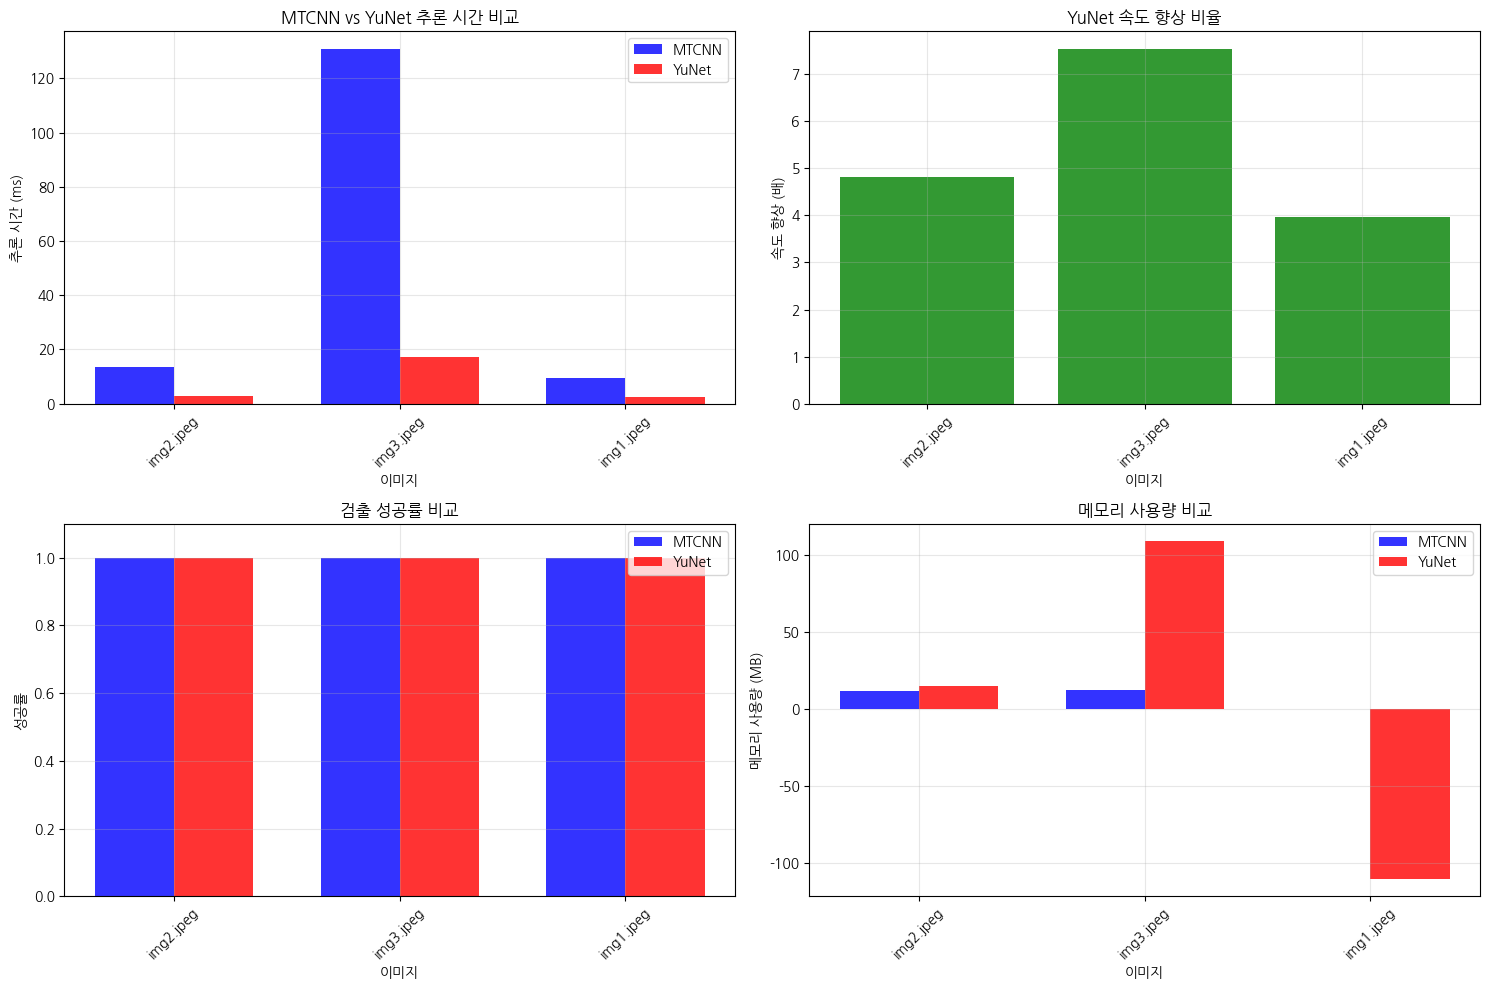

In [9]:
# 시각화
if benchmark_results and len(benchmark_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 추론 시간 비교
    ax1 = axes[0, 0]
    x_pos = np.arange(len(df_results))
    width = 0.35
    
    ax1.bar(x_pos - width/2, df_results['mtcnn_time_ms'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax1.bar(x_pos + width/2, df_results['yunet_time_ms'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax1.set_xlabel('이미지')
    ax1.set_ylabel('추론 시간 (ms)')
    ax1.set_title('MTCNN vs YuNet 추론 시간 비교')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_results['image'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 속도 향상 비율
    ax2 = axes[0, 1]
    ax2.bar(x_pos, df_results['speedup_ratio'], alpha=0.8, color='green')
    ax2.set_xlabel('이미지')
    ax2.set_ylabel('속도 향상 (배)')
    ax2.set_title('YuNet 속도 향상 비율')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_results['image'], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. 성공률 비교
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, df_results['mtcnn_success_rate'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax3.bar(x_pos + width/2, df_results['yunet_success_rate'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax3.set_xlabel('이미지')
    ax3.set_ylabel('성공률')
    ax3.set_title('검출 성공률 비교')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(df_results['image'], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.1)
    
    # 4. 메모리 사용량 비교
    ax4 = axes[1, 1]
    ax4.bar(x_pos - width/2, df_results['mtcnn_memory_mb'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax4.bar(x_pos + width/2, df_results['yunet_memory_mb'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax4.set_xlabel('이미지')
    ax4.set_ylabel('메모리 사용량 (MB)')
    ax4.set_title('메모리 사용량 비교')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(df_results['image'], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("시각화할 데이터가 없습니다.")

## 7. Face Alignment 결과 시각적 비교

시각적 비교 대상: img2.jpeg


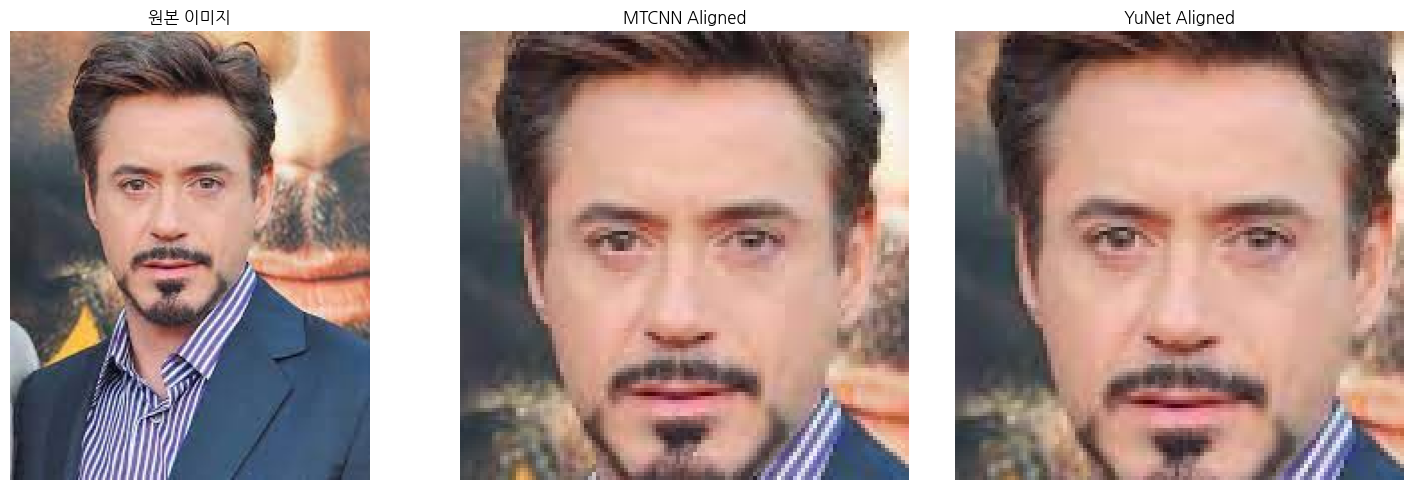


EdgeFace Embedding 비교:
코사인 유사도: 0.9850
임베딩 차이 (L2): 0.0549


In [10]:
# 첫 번째 테스트 이미지로 시각적 비교
global yunet_detector, yunet_available

if test_images:
    test_image_path = test_images[0]
    print(f"시각적 비교 대상: {os.path.basename(test_image_path)}")
    
    try:
        # 원본 이미지 로드
        original_img = Image.open(test_image_path).convert('RGB')
        
        # MTCNN alignment
        mtcnn_aligned = get_aligned_face_cpu(test_image_path)
        
        # YuNet alignment  
        if yunet_available and yunet_detector is not None:
            yunet_aligned = yunet_detector.align(original_img)
        else:
            yunet_aligned = None
            print("YuNet을 사용할 수 없습니다.")
        
        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 원본 이미지
        axes[0].imshow(original_img)
        axes[0].set_title('원본 이미지')
        axes[0].axis('off')
        
        # MTCNN 결과
        if mtcnn_aligned is not None:
            axes[1].imshow(mtcnn_aligned)
            axes[1].set_title('MTCNN Aligned')
        else:
            axes[1].text(0.5, 0.5, 'Detection Failed', 
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('MTCNN (실패)')
        axes[1].axis('off')
        
        # YuNet 결과
        if yunet_available and yunet_aligned is not None:
            axes[2].imshow(yunet_aligned)
            axes[2].set_title('YuNet Aligned')
        elif not yunet_available:
            axes[2].text(0.5, 0.5, 'YuNet Unavailable', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('YuNet (사용 불가)')
        else:
            axes[2].text(0.5, 0.5, 'Detection Failed', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('YuNet (실패)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # EdgeFace embedding 비교
        if mtcnn_aligned is not None and yunet_available and yunet_aligned is not None:
            mtcnn_embedding = get_edgeface_embedding(mtcnn_aligned)
            yunet_embedding = get_edgeface_embedding(yunet_aligned)
            
            if mtcnn_embedding is not None and yunet_embedding is not None:
                # 코사인 유사도 계산
                cos_sim = torch.nn.functional.cosine_similarity(
                    mtcnn_embedding, yunet_embedding
                ).item()
                
                print(f"\nEdgeFace Embedding 비교:")
                print(f"코사인 유사도: {cos_sim:.4f}")
                print(f"임베딩 차이 (L2): {torch.norm(mtcnn_embedding - yunet_embedding).item():.4f}")
            else:
                print("EdgeFace embedding 추출에 실패했습니다.")
        elif not yunet_available:
            print("\nYuNet을 사용할 수 없어 embedding 비교를 건너뜁니다.")
        else:
            print("\nFace detection이 실패하여 embedding 비교를 할 수 없습니다.")
        
    except Exception as e:
        print(f"시각적 비교 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
else:
    print("비교할 테스트 이미지가 없습니다.")

In [11]:
## 8. Face Alignment 결과 시각적 비교

## 7. 바운딩 박스 및 랜드마크 시각화 비교

바운딩 박스 및 랜드마크 비교 대상: img2.jpeg


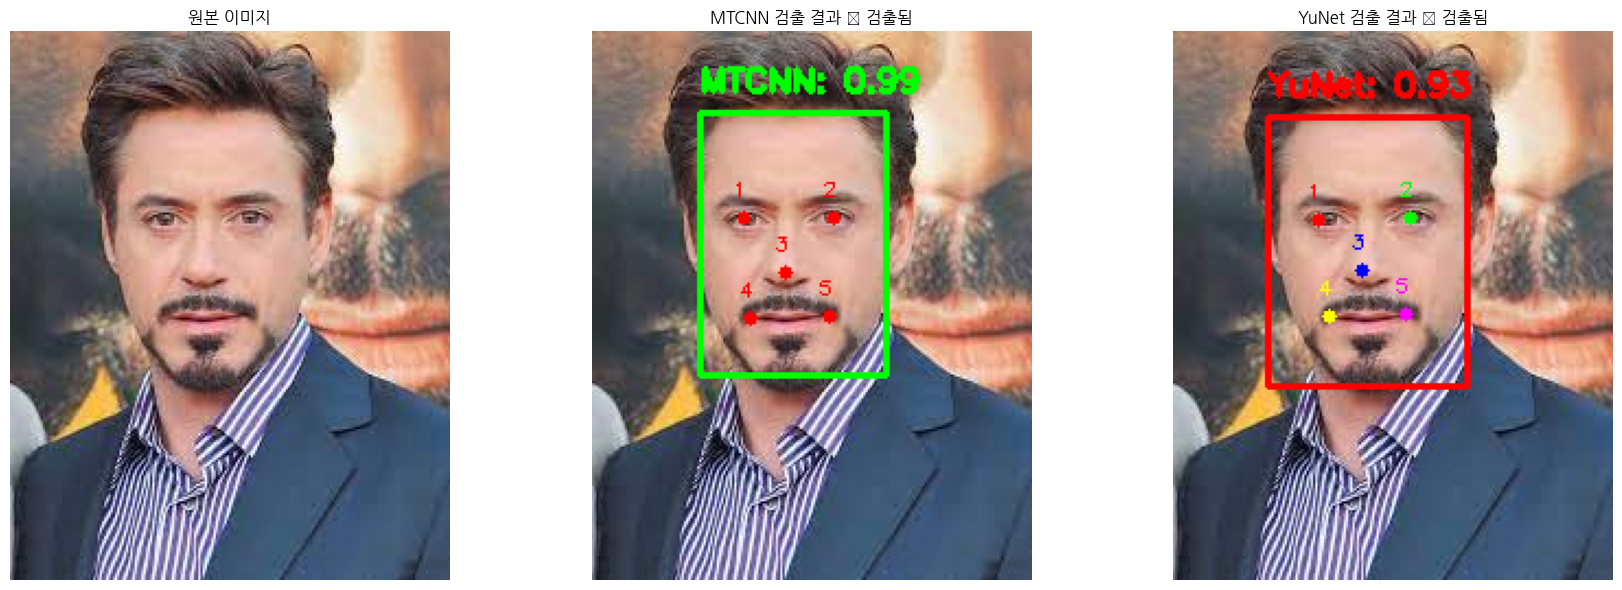


=== 검출 결과 요약 ===
MTCNN 검출: 성공
YuNet 검출: 성공

범례:
• 녹색 박스: MTCNN 바운딩 박스
• 파란색 박스: YuNet 바운딩 박스
• 숫자 1-5: 랜드마크 순서 (1: 우측 눈, 2: 좌측 눈, 3: 코, 4: 우측 입꼬리, 5: 좌측 입꼬리)
• 박스 위 숫자: Confidence Score


In [12]:
# 바운딩 박스와 랜드마크 시각화 비교 함수
def visualize_detection_comparison(image_path):
    """
    MTCNN과 YuNet의 검출 결과(바운딩 박스 + 랜드마크)를 비교하여 시각화합니다.
    """
    global yunet_detector, yunet_available
    
    # 원본 이미지 로드
    original_img = Image.open(image_path).convert('RGB')
    original_np = np.array(original_img)
    
    # 결과를 저장할 이미지들
    mtcnn_result = original_np.copy()
    yunet_result = original_np.copy()
    
    # MTCNN 검출 및 시각화
    try:
        # 기존 MTCNN 모듈 사용 (align_cpu.py의 mtcnn_model 활용)
        from face_alignment.align_cpu import mtcnn_model
        
        # MTCNN으로 검출 (detect_faces 메서드 사용)
        bboxes, landmarks = mtcnn_model.detect_faces(
            original_img, 
            min_face_size=20, 
            thresholds=[0.6, 0.7, 0.7], 
            nms_thresholds=[0.7, 0.7, 0.7], 
            factor=0.709
        )
        
        # MTCNN 결과 시각화
        if len(bboxes) > 0:
            for i, bbox in enumerate(bboxes):
                # 바운딩 박스 그리기
                cv.rectangle(mtcnn_result, 
                           (int(bbox[0]), int(bbox[1])), 
                           (int(bbox[2]), int(bbox[3])), 
                           (0, 255, 0), 2)
                
                # 랜드마크 그리기 (5개 점)
                if len(landmarks) > i:
                    landmark = landmarks[i]
                    # landmarks는 [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5] 형태
                    for j in range(5):
                        x, y = int(landmark[j]), int(landmark[j+5])
                        cv.circle(mtcnn_result, (x, y), 3, (255, 0, 0), -1)
                        cv.putText(mtcnn_result, str(j+1), (x-5, y-10), 
                                 cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                
                # confidence score 표시
                confidence = bbox[4] if len(bbox) > 4 else 0.0
                cv.putText(mtcnn_result, f'MTCNN: {confidence:.2f}', 
                         (int(bbox[0]), int(bbox[1]-10)), 
                         cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        mtcnn_detected = len(bboxes) > 0
        
    except Exception as e:
        print(f"MTCNN 검출 오류: {e}")
        import traceback
        traceback.print_exc()
        mtcnn_detected = False
        # 오류 메시지 표시
        cv.putText(mtcnn_result, 'MTCNN Detection Failed', 
                 (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # YuNet 검출 및 시각화
    yunet_detected = False
    if yunet_available and yunet_detector is not None:
        try:
            # 이미지를 OpenCV 형식으로 변환
            cv_img = cv.cvtColor(original_np, cv.COLOR_RGB2BGR)
            
            # YuNet 검출
            yunet_detector.detector.setInputSize((cv_img.shape[1], cv_img.shape[0]))
            _, faces = yunet_detector.detector.detect(cv_img)
            
            if faces is not None and len(faces) > 0:
                for face in faces:
                    # 바운딩 박스 좌표 (x, y, w, h, confidence)
                    x, y, w, h = int(face[0]), int(face[1]), int(face[2]), int(face[3])
                    confidence = face[14] if len(face) > 14 else 0.0
                    
                    # 바운딩 박스 그리기
                    cv.rectangle(yunet_result, (x, y), (x+w, y+h), (255, 0, 0), 2)
                    
                    # 랜드마크 그리기 (우측 눈, 좌측 눈, 코, 우측 입꼬리, 좌측 입꼬리)
                    landmarks_yunet = [
                        (int(face[4]), int(face[5])),   # 우측 눈
                        (int(face[6]), int(face[7])),   # 좌측 눈  
                        (int(face[8]), int(face[9])),   # 코
                        (int(face[10]), int(face[11])), # 우측 입꼬리
                        (int(face[12]), int(face[13]))  # 좌측 입꼬리
                    ]
                    
                    landmark_names = ['R_eye', 'L_eye', 'nose', 'R_mouth', 'L_mouth']
                    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
                    
                    for j, ((lx, ly), name, color) in enumerate(zip(landmarks_yunet, landmark_names, colors)):
                        cv.circle(yunet_result, (lx, ly), 3, color, -1)
                        cv.putText(yunet_result, str(j+1), (lx-5, ly-10), 
                                 cv.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
                    
                    # confidence score 표시
                    cv.putText(yunet_result, f'YuNet: {confidence:.2f}', 
                             (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                yunet_detected = True
            else:
                # 검출 실패 메시지
                cv.putText(yunet_result, 'YuNet: No Face Detected', 
                         (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        except Exception as e:
            print(f"YuNet 검출 오류: {e}")
            cv.putText(yunet_result, 'YuNet Detection Failed', 
                     (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    else:
        cv.putText(yunet_result, 'YuNet Not Available', 
                 (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (128, 128, 128), 2)
    
    return mtcnn_result, yunet_result, mtcnn_detected, yunet_detected

# 첫 번째 테스트 이미지로 바운딩 박스 및 랜드마크 비교
if test_images:
    test_image_path = test_images[0]
    print(f"바운딩 박스 및 랜드마크 비교 대상: {os.path.basename(test_image_path)}")
    
    try:
        # 검출 결과 시각화
        mtcnn_result, yunet_result, mtcnn_detected, yunet_detected = visualize_detection_comparison(test_image_path)
        
        # 원본 이미지도 로드
        original_img = Image.open(test_image_path).convert('RGB')
        
        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 원본 이미지
        axes[0].imshow(original_img)
        axes[0].set_title('원본 이미지')
        axes[0].axis('off')
        
        # MTCNN 검출 결과
        axes[1].imshow(mtcnn_result)
        detection_status = "✅ 검출됨" if mtcnn_detected else "❌ 검출 실패"
        axes[1].set_title(f'MTCNN 검출 결과 {detection_status}')
        axes[1].axis('off')
        
        # YuNet 검출 결과
        axes[2].imshow(yunet_result)
        if yunet_available:
            detection_status = "✅ 검출됨" if yunet_detected else "❌ 검출 실패"
            axes[2].set_title(f'YuNet 검출 결과 {detection_status}')
        else:
            axes[2].set_title('YuNet (사용 불가)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 검출 결과 요약
        print("\n=== 검출 결과 요약 ===")
        print(f"MTCNN 검출: {'성공' if mtcnn_detected else '실패'}")
        if yunet_available:
            print(f"YuNet 검출: {'성공' if yunet_detected else '실패'}")
        else:
            print(f"YuNet 검출: 사용 불가")
        
        print(f"\n범례:")
        print(f"• 녹색 박스: MTCNN 바운딩 박스")
        print(f"• 파란색 박스: YuNet 바운딩 박스")
        print(f"• 숫자 1-5: 랜드마크 순서 (1: 우측 눈, 2: 좌측 눈, 3: 코, 4: 우측 입꼬리, 5: 좌측 입꼬리)")
        print(f"• 박스 위 숫자: Confidence Score")
        
    except Exception as e:
        print(f"바운딩 박스 시각화 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
else:
    print("비교할 테스트 이미지가 없습니다.")

## 8. 결론 및 권장사항

In [13]:
print("=== EdgeFace 평가를 위한 MTCNN vs YuNet 비교 결론 ===")
print()

if not yunet_available:
    print("⚠️ YuNet을 사용할 수 없어 비교 분석이 제한됩니다.")
    print("MTCNN만 사용 가능한 상태입니다.")
    print()
    print("💡 권장사항:")
    print("  • OpenCV 4.5.4 이상이 설치되어 있는지 확인하세요")
    print("  • YuNet ONNX 모델 파일의 경로를 확인하세요")
    print("  • 현재는 MTCNN을 사용하여 EdgeFace 평가를 진행하세요")
elif benchmark_results:
    avg_mtcnn_time = np.mean([r['mtcnn_time_ms'] for r in benchmark_results])
    avg_yunet_time = np.mean([r['yunet_time_ms'] for r in benchmark_results if r['yunet_time_ms'] > 0])
    avg_speedup = np.mean([r['speedup_ratio'] for r in benchmark_results if r['speedup_ratio'] > 0])
    avg_mtcnn_success = np.mean([r['mtcnn_success_rate'] for r in benchmark_results])
    avg_yunet_success = np.mean([r['yunet_success_rate'] for r in benchmark_results if r['yunet_success_rate'] > 0])
    
    print(f"📊 성능 요약:")
    print(f"  • MTCNN 평균 추론시간: {avg_mtcnn_time:.1f}ms")
    if avg_yunet_time > 0:
        print(f"  • YuNet 평균 추론시간: {avg_yunet_time:.1f}ms")
        print(f"  • 속도 향상: {avg_speedup:.2f}배")
    print(f"  • MTCNN 성공률: {avg_mtcnn_success:.1%}")
    if avg_yunet_success > 0:
        print(f"  • YuNet 성공률: {avg_yunet_success:.1%}")
    print()
    
    if avg_yunet_time > 0:
        print(f"🔍 분석 결과:")
        if avg_speedup > 1:
            print(f"  ✅ YuNet이 MTCNN보다 {avg_speedup:.2f}배 빠름")
        else:
            print(f"  ⚠️  MTCNN이 YuNet보다 {1/avg_speedup:.2f}배 빠름")
        
        if avg_yunet_success >= avg_mtcnn_success:
            print(f"  ✅ YuNet 검출 성공률이 동등하거나 더 높음")
        else:
            print(f"  ⚠️  MTCNN 검출 성공률이 더 높음")
            
        print()
        print(f"💡 EdgeFace-XS(γ=0.6) 평가를 위한 권장사항:")
        
        if avg_speedup > 2 and avg_yunet_success >= 0.8:
            print(f"  ✅ YuNet 사용 권장 - 속도 이점이 크고 안정적")
        elif avg_speedup > 1.5:
            print(f"  📈 YuNet 사용 고려 - 속도 이점 있음")
        else:
            print(f"  🔄 MTCNN 유지 권장 - 성능 차이가 크지 않음")
    else:
        print(f"🔍 분석 결과:")
        print(f"  • YuNet 비교 데이터 없음 - MTCNN만 테스트됨")
        print(f"💡 EdgeFace-XS(γ=0.6) 평가를 위한 권장사항:")
        print(f"  🔄 현재 MTCNN 사용 권장")
            
    print(f"  • CPU 환경에서의 추론 속도 최적화 확인")
    print(f"  • Face alignment 일관성 확인 필요")
    print(f"  • 대규모 데이터셋 평가 시 처리량 이점 고려")
    
else:
    print("벤치마크 데이터가 없어 결론을 도출할 수 없습니다.")
    print("테스트 이미지와 모델 설정을 확인해주세요.")

print()
print("📝 추가 고려사항:")
if yunet_available:
    print("  • YuNet은 OpenCV DNN 백엔드를 사용하여 다양한 플랫폼에서 최적화됨")
    print("  • MTCNN은 PyTorch 기반으로 GPU 가속 시 더 큰 이점")
    print("  • 실제 EdgeFace 성능 평가 시 동일한 face alignment 사용 권장")
    print("  • 배치 처리 시 YuNet의 메모리 효율성 확인 필요")
else:
    print("  • YuNet 설정 완료 후 다시 비교 실행")
    print("  • MTCNN CPU 버전으로 현재 EdgeFace 평가 가능")
    print("  • OpenCV 버전 및 YuNet 모델 파일 확인 필요")

=== EdgeFace 평가를 위한 MTCNN vs YuNet 비교 결론 ===

📊 성능 요약:
  • MTCNN 평균 추론시간: 51.3ms
  • YuNet 평균 추론시간: 7.5ms
  • 속도 향상: 5.44배
  • MTCNN 성공률: 100.0%
  • YuNet 성공률: 100.0%

🔍 분석 결과:
  ✅ YuNet이 MTCNN보다 5.44배 빠름
  ✅ YuNet 검출 성공률이 동등하거나 더 높음

💡 EdgeFace-XS(γ=0.6) 평가를 위한 권장사항:
  ✅ YuNet 사용 권장 - 속도 이점이 크고 안정적
  • CPU 환경에서의 추론 속도 최적화 확인
  • Face alignment 일관성 확인 필요
  • 대규모 데이터셋 평가 시 처리량 이점 고려

📝 추가 고려사항:
  • YuNet은 OpenCV DNN 백엔드를 사용하여 다양한 플랫폼에서 최적화됨
  • MTCNN은 PyTorch 기반으로 GPU 가속 시 더 큰 이점
  • 실제 EdgeFace 성능 평가 시 동일한 face alignment 사용 권장
  • 배치 처리 시 YuNet의 메모리 효율성 확인 필요


## 9. 결과 저장

In [14]:
# 벤치마크 결과를 CSV로 저장
if benchmark_results:
    df_results = pd.DataFrame(benchmark_results)
    
    # 결과 저장
    output_dir = Path('benchmark_results')
    output_dir.mkdir(exist_ok=True)
    
    # CSV 저장
    csv_path = output_dir / 'mtcnn_vs_yunet_benchmark.csv'
    df_results.to_csv(csv_path, index=False)
    print(f"벤치마크 결과 저장: {csv_path}")
    
    # 요약 통계 저장
    summary = {
        'avg_mtcnn_time_ms': df_results['mtcnn_time_ms'].mean(),
        'avg_yunet_time_ms': df_results['yunet_time_ms'].mean(),
        'avg_speedup_ratio': df_results['speedup_ratio'].mean(),
        'mtcnn_success_rate': df_results['mtcnn_success_rate'].mean(),
        'yunet_success_rate': df_results['yunet_success_rate'].mean(),
        'total_images_tested': len(df_results)
    }
    
    summary_path = output_dir / 'benchmark_summary.json'
    import json
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"요약 통계 저장: {summary_path}")
    
    print("\n모든 결과가 저장되었습니다.")
else:
    print("저장할 벤치마크 결과가 없습니다.")

벤치마크 결과 저장: benchmark_results/mtcnn_vs_yunet_benchmark.csv
요약 통계 저장: benchmark_results/benchmark_summary.json

모든 결과가 저장되었습니다.
